In [1]:
import argparse
import os
import time
from pathlib import Path

import numpy as np
import pytorch_lightning as pl
import torch
import wandb
from torch import nn
from torch.nn import functional as F
from torchvision import datasets
from torch.utils.data import DataLoader, random_split
from torchvision import models, transforms
from torchvision.datasets import CIFAR10
import timm # state-of-the-art models (e.g. vit...)

from tqdm import tqdm

from wide_resnet import WideResNet

In [ ]:
parser = argparse.ArgumentParser()
parser.add_argument("--lr", default=0.1, type=float)
parser.add_argument("--epochs", default=1, type=int)
parser.add_argument("--n_shadows", default=16, type=int)
parser.add_argument("--shadow_id", default=1, type=int)
parser.add_argument("--model", default="", type=str)
parser.add_argument("--pkeep", default=0.5, type=float)
parser.add_argument("--savedir", default="exp/imagenet-1k", type=str)
parser.add_argument("--debug", action="store_true")
args = parser.parse_args()


In [13]:
m = network("efficientnet_b7", pretrained_=True)
m

arch: efficientnet_b7, pretrained: True


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64, bias=False)
            (1): BatchNorm2d(64, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(64, 16, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormAct

In [16]:
# for ViT, 
# for name, param in m.named_parameters():
#    if "head" not in name:
#        param.requires_grad = False


# for efficientnet-b7
for param in m.parameters():
    param.requires_grad = False
for param in m.classifier[1].parameters():
    param.requires_grad = True

In [17]:

# Verify the layers are frozen
for name, param in m.named_parameters():
    print(f"{name}: requires_grad = {param.requires_grad}")


features.0.0.weight: requires_grad = False
features.0.1.weight: requires_grad = False
features.0.1.bias: requires_grad = False
features.1.0.block.0.0.weight: requires_grad = False
features.1.0.block.0.1.weight: requires_grad = False
features.1.0.block.0.1.bias: requires_grad = False
features.1.0.block.1.fc1.weight: requires_grad = False
features.1.0.block.1.fc1.bias: requires_grad = False
features.1.0.block.1.fc2.weight: requires_grad = False
features.1.0.block.1.fc2.bias: requires_grad = False
features.1.0.block.2.0.weight: requires_grad = False
features.1.0.block.2.1.weight: requires_grad = False
features.1.0.block.2.1.bias: requires_grad = False
features.1.1.block.0.0.weight: requires_grad = False
features.1.1.block.0.1.weight: requires_grad = False
features.1.1.block.0.1.bias: requires_grad = False
features.1.1.block.1.fc1.weight: requires_grad = False
features.1.1.block.1.fc1.bias: requires_grad = False
features.1.1.block.1.fc2.weight: requires_grad = False
features.1.1.block.1.fc

In [12]:
import argparse
import os
import time
from pathlib import Path

import numpy as np
import pytorch_lightning as pl
import torch
import wandb
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torchvision import models, transforms
from torchvision.datasets import CIFAR10
import timm # state-of-the-art models (e.g. vit...)

from tqdm import tqdm

from wide_resnet import WideResNet

def network(arch: str, pretrained_: bool):
    print(f'arch: {arch}, pretrained: {pretrained_}') 
    
    # https://pytorch.org/vision/stable/models.html
    TORCHVISION_MODELS = ['resnet18', 'resnet50', 'resnet101', 'vgg16', 'vgg19', 'densenet121', 
                          'wide_resnet50_2', 'wide_resnet101_2',
                          'densenet201', 'mobilenet_v2', 'inception_v3', 
                          'efficientnet_b0', 'efficientnet_b7', 
                          'squeezenet1_0', 'alexnet', 'googlenet', 'shufflenet_v2_x1_0']
    
    # https://github.com/huggingface/pytorch-image-models
    PYTORCH_IMAGE_MODELS = ['vit_base_patch16_224', 'vit_large_patch16_224', 'deit_base_patch16_224',
                        'convnext_base', 'convnext_large']
    
    if arch in TORCHVISION_MODELS:
        model = models.__dict__[arch](pretrained=pretrained_)
    elif arch in PYTORCH_IMAGE_MODELS:
        model = timm.create_model(arch, pretrained=pretrained_)
    else:
        raise ValueError(f"Model {model_name} not available.")

    _model  = "efficientnet_b7"
    _dataset = "cifar10"

    dataset_classes = {"cifar10": 10, "cifar100": 100}
    n_classes = dataset_classes.get(_dataset)
    
    if not n_classes:
        raise ValueError(f"Unsupported dataset '{args.dataset}'")

    if _model == "vgg19": # for VGG-19
        num_features = model.classifier[6].in_features
        m.classifier[6] = nn.Linear(num_features, n_classes)      
    elif _model == "vit_large_patch16_224": # for ViT (vision transformer) 
        num_features = model.head.in_features
        model.head = nn.Linear(num_features, n_classes)        
    elif _model == "efficientnet_b7": # for efficientnet
        in_features = model.classifier[1].in_features
        model.classifier[1] = nn.Linear(in_features, n_classes)
    else:
        raise ValueError("undefined dataset")    
        
    return model

In [ ]:
from torchvision import datasets
from torch.utils.data import DataLoader, random_split

DATA_DIR = '/serenity/scratch/psml/repo/psml/data/ILSVRC2012'

transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

imagenet = datasets.ImageNet(root=DATA_DIR, split='val', transform=transform)

In [ ]:
imagenet

In [ ]:
train_ds, test_ds = random_split(imagenet, [0.8, 0.2])


In [ ]:
len(test_ds)

In [ ]:
for epoch in tqdm(range(args.epochs), desc="training epochs..."):
    m.train()
    loss_total = 0
    pbar = tqdm(train_dl)

    for itr, (x, y) in enumerate(pbar):

    loss = F.cross_entropy(m(x), y)

In [ ]:
train_dl = DataLoader(train_ds, batch_size=128, shuffle=True, num_workers=4)
test_dl = DataLoader(test_ds, batch_size=128, shuffle=False, num_workers=4)

In [ ]:
iterator = iter(train_dl)

In [ ]:
x, y = next(iterator)

In [ ]:
x.shape

In [ ]:
x

In [ ]:
y.shape

In [ ]:
y

In [ ]:
preds = m(x)

In [ ]:
preds

In [ ]:
preds.shape

In [ ]:
loss = F.cross_entropy(preds, y)

In [ ]:
loss

In [ ]:
loss_total = 0

In [ ]:
loss_total += loss

In [ ]:
loss_total

In [ ]:
f"loss: {loss:.2f}"

In [ ]:
print(torch.unique(y))

In [ ]:

train_transform = transforms.Compose(
[
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize([0.4914, 0.4822, 0.4465], [0.2470, 0.2435, 0.2616]),
]
)
test_transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize([0.4914, 0.4822, 0.4465], [0.2470, 0.2435, 0.2616]),
    ]
)
datadir = Path().home() / "TFDS"
c_train_ds = CIFAR10(root=datadir, train=True, download=True, transform=train_transform)
c_test_ds = CIFAR10(root=datadir, train=False, download=True, transform=test_transform)


In [ ]:
len(c_train_ds)

In [ ]:
len(c_test_ds)

In [ ]:
loss

In [ ]:
loss.item()

In [ ]:
train_dl

In [ ]:
train_ds.device

In [ ]:
m_ = network("vgg19")

In [ ]:
m_

In [ ]:
for params in m_.parameters():
    print(params)

In [ ]:
path = "exp/imagenet-1k/experiment-0_64"
exp_0_64_model = torch.load(os.path.join(path, "model.pt"))

In [ ]:
exp_0_64_model

In [ ]:

m.load_state_dict(exp_0_64_model)

In [ ]:
for params in m_.parameters():
    print(params)

In [ ]:
def compare_model_params(model, checkpoint):
#     model_state_dict = model.state_dict()

#     checkpoint_state_dict = checkpoint['state_dict'] if 'state_dict' in checkpoint else checkpoint
    
    model_state_dict = {k: v.cpu() for k, v in model.state_dict().items()}

    # checkpoint의 state_dict 가져오기 (모두 CPU로 이동)
    checkpoint_state_dict = {k: v.cpu() for k, v in (checkpoint['state_dict'] if 'state_dict' in checkpoint else checkpoint).items()}


    for param_tensor in model_state_dict:
        
#         print("param_tensor: ", param_tensor)
        
        model_param = model_state_dict[param_tensor]
        checkpoint_param = checkpoint_state_dict[param_tensor]
        
#         print(model_param.device, checkpoint_param.device)

        if torch.equal(model_param, checkpoint_param):
            print(f"{param_tensor}: Parameters match.")
        else:
            print(f"{param_tensor}: Parameters do not match.")

In [ ]:
compare_model_params(m, exp_0_64_model)

In [ ]:
torch.cuda.device_count()

In [ ]:
c_train_ds

In [15]:
# Dataset: imagenet-1k
DATA_DIR = '/serenity/scratch/psml/repo/psml/data/ILSVRC2012'

transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

imagenet = datasets.ImageNet(root=DATA_DIR, split='val', transform=transform)
train_ds, test_ds = random_split(imagenet, [0.8, 0.2])

In [26]:
import matplotlib.pyplot as plt

# Function to display one image per class
def show_one_image_per_class(dataset, num_images=20):
    seen_classes = set()
    images_to_show = []
    
    for img, label in dataset:
#         print("seen_classes: ", seen_classes)
        if label not in seen_classes:
            images_to_show.append((img, label))
            seen_classes.add(label)
        if len(images_to_show) >= num_images:
            break
    
    # Plot the images
    fig, axes = plt.subplots(4, 5, figsize=(16, 16))
    for i, (img, label) in enumerate(images_to_show):
        img = img.permute(1, 2, 0)  # Convert from (C, H, W) to (H, W, C)
        img = img * torch.tensor([0.229, 0.224, 0.225]) + torch.tensor([0.485, 0.456, 0.406])  # Unnormalize
        img = img.clamp(0, 1)
        ax = axes[i // 5, i % 5]
        ax.imshow(img)
        ax.set_title(f'Label: {imagenet.classes[label]}')
        ax.axis('off')
    
    plt.show()

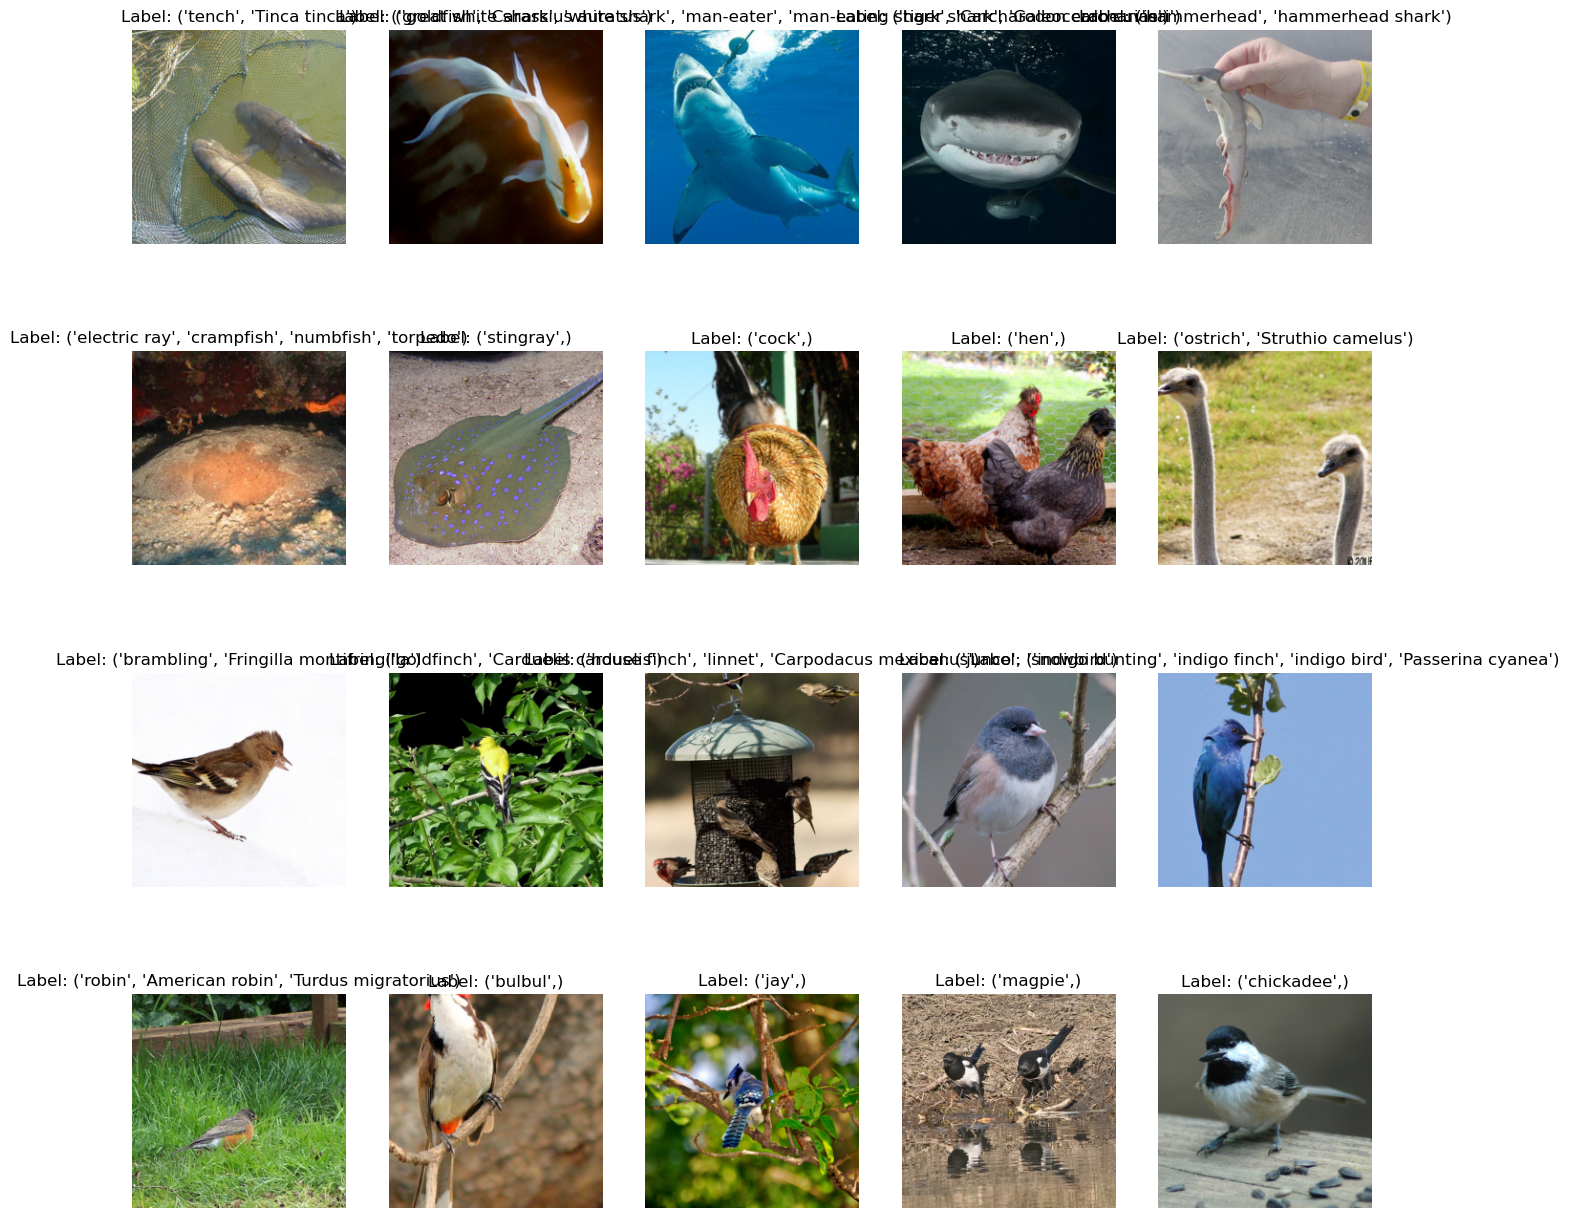

In [30]:
# Display 20 images with their labels
show_one_image_per_class(imagenet, num_images=20)

In [ ]:
train_ds

In [ ]:
train_ds

In [ ]:
subset_targets = [train_ds.dataset.targets[i] for i in train_ds.indices]

In [ ]:
train_ds.dataset.targets

In [ ]:
train_ds.indices

In [ ]:
type(subset_targets)

In [ ]:
SEED = 1583745484
pl.seed_everything(SEED)

In [ ]:
DATA_DIR = '/serenity/scratch/psml/repo/psml/data/ILSVRC2012'

transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

imagenet = datasets.ImageNet(root=DATA_DIR, split='val', transform=transform)
train_ds, test_ds = random_split(imagenet, [0.8, 0.2])

print("train_ds: ", train_ds.indices[:100])

In [ ]:
n_shadows = 64

size = len(train_ds)
np.random.seed(SEED)
if n_shadows is not None:
    print("n_shadows: ", n_shadows)
    np.random.seed(SEED)
    keep = np.random.uniform(0, 1, size=(n_shadows, size))
    order = keep.argsort(0)
    keep = order < int(0.5 * n_shadows)
    keep = np.array(keep[3], dtype=bool)
    keep = keep.nonzero()[0]
else:
    keep = np.random.choice(size, size=int(0.5 * size), replace=False)
    keep.sort()
keep_bool = np.full((size), False)
keep_bool[keep] = True

In [ ]:
len(keep)

In [ ]:
train_ds = torch.utils.data.Subset(train_ds, keep)

In [ ]:
vit = network("vit_large_patch16_224")

In [ ]:
vit